In [230]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pickle

In [116]:
data = pd.read_csv('/content/melb_data.csv')

In [117]:
data.head(2).T

,0,1
Suburb,Abbotsford,Abbotsford
Address,85 Turner St,25 Bloomburg St
Rooms,2,2
Type,h,h
Price,1480000.0,1035000.0
Method,S,S
SellerG,Biggin,Biggin
Date,3/12/2016,4/02/2016
Distance,2.5,2.5
Postcode,3067.0,3067.0


In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [119]:
def count_outliers_by_type_suburb(df):
    outlier_counts = []

    for t in df['Type'].unique():
        for sub in df['Suburb'].unique():
            subset = df[(df['Type'] == t) & (df['Suburb'] == sub)]

            if subset.empty or subset['BuildingArea'].isna().all():
                # Skip if no data or all NaN
                continue

            areas = subset['BuildingArea'].dropna()
            Q1 = areas.quantile(0.25)
            Q3 = areas.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Count outliers below lower bound or above upper bound
            outliers = areas[(areas < lower_bound) | (areas > upper_bound)]
            count = outliers.count()

            if count > 0:
                outlier_counts.append({
                    'Type': t,
                    'Suburb': sub,
                    'OutlierCount': count,
                    'TotalCount': len(areas),
                    'OutlierRatio': count / len(areas)
                })

    return pd.DataFrame(outlier_counts)

In [120]:
outliers_df = count_outliers_by_type_suburb(data)
print(outliers_df.sort_values(by='OutlierCount', ascending=False))

    Type          Suburb  OutlierCount  TotalCount  OutlierRatio
64     h       Reservoir            12         105      0.114286
63     h         Preston             9          94      0.095745
11     h  Bentleigh East             7          85      0.082353
69     h        Sunshine             7          42      0.166667
61     h     Pascoe Vale             6          59      0.101695
..   ...             ...           ...         ...           ...
211    t     Maribyrnong             1          15      0.066667
217    t  West Melbourne             1           6      0.166667
216    t       Thornbury             1           7      0.142857
221    t   Hawthorn East             1           5      0.200000
222    t         Mentone             1           6      0.166667

[223 rows x 5 columns]


In [121]:
def remove_outliers_by_suburb_type(df, column='BuildingArea'):
    cleaned_frames = []

    # Group by Suburb and Type
    grouped = df.groupby(['Suburb', 'Type'])

    for (suburb, h_type), group in grouped:
        # Drop NA in the target column for calculation
        values = group[column].dropna()
        if len(values) == 0:
            # No values to check, keep group as is
            cleaned_frames.append(group)
            continue

        Q1 = values.quantile(0.25)
        Q3 = values.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter group to only keep rows within bounds or with NA in that column
        filtered_group = group[(group[column].isna()) | ((group[column] >= lower_bound) & (group[column] <= upper_bound))]

        cleaned_frames.append(filtered_group)

    # Concatenate all filtered groups back together
    cleaned_df = pd.concat(cleaned_frames).reset_index(drop=True)
    return cleaned_df

In [122]:
data = remove_outliers_by_suburb_type(data)

In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13152 entries, 0 to 13151
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13152 non-null  object 
 1   Address        13152 non-null  object 
 2   Rooms          13152 non-null  int64  
 3   Type           13152 non-null  object 
 4   Price          13152 non-null  float64
 5   Method         13152 non-null  object 
 6   SellerG        13152 non-null  object 
 7   Date           13152 non-null  object 
 8   Distance       13152 non-null  float64
 9   Postcode       13152 non-null  float64
 10  Bedroom2       13152 non-null  float64
 11  Bathroom       13152 non-null  float64
 12  Car            13090 non-null  float64
 13  Landsize       13152 non-null  float64
 14  BuildingArea   6702 non-null   float64
 15  YearBuilt      7837 non-null   float64
 16  CouncilArea    11825 non-null  object 
 17  Lattitude      13152 non-null  float64
 18  Longti

In [124]:
outliers_df = count_outliers_by_type_suburb(data)
print(outliers_df.sort_values(by='OutlierCount', ascending=False))

   Type          Suburb  OutlierCount  TotalCount  OutlierRatio
13    h          Coburg             4          78      0.051282
11    h        Bundoora             4          17      0.235294
10    h         Bulleen             4          25      0.160000
30    h        Oak Park             4          18      0.222222
43    h      Yarraville             4          78      0.051282
..  ...             ...           ...         ...           ...
56    u      Ascot Vale             1          12      0.083333
58    u          Coburg             1          10      0.100000
57    u         Carlton             1           6      0.166667
60    u  Port Melbourne             1          29      0.034483
59    u        Essendon             1          33      0.030303

[63 rows x 5 columns]


In [125]:
data = data[(data['BuildingArea']<10000) | (data['BuildingArea'].isna())]

In [126]:
data = data[(data['Price']<6000000)]

In [127]:
Suburb = data['Suburb'].unique()

In [128]:
Region = data['Regionname'].unique()

In [129]:
house_type = data['Type'].unique()

In [130]:
cars = data['Car'].unique()

In [131]:
councilArea = data['CouncilArea'].unique()

In [132]:
from collections import defaultdict

In [133]:
sub_dict = defaultdict(list)

In [134]:
def is_suburb_in_region(suburb_name, region_name):
    return not data[(data['Suburb'] == suburb_name) & (data['Regionname'] == region_name)].empty

In [135]:
for i in range(len(Suburb)):
  mean_year_per_sub = data[data['Suburb'] == Suburb[i]]['YearBuilt'].mean()
  if pd.isna(mean_year_per_sub):
    for j in range(len(Region)):
      if is_suburb_in_region(Suburb[i], Region[j]):
        mean_year_per_region = data[data['Regionname'] == Region[j]]['YearBuilt'].mean()
        sub_dict[Suburb[i]].append(mean_year_per_region)
        break
  else:
    sub_dict[Suburb[i]].append(mean_year_per_sub)



In [136]:
sub_dict

defaultdict(list,
            {'Abbotsford': [np.float64(1946.1351351351352)],
             'Aberfeldie': [np.float64(1976.75)],
             'Airport West': [np.float64(1984.5853658536585)],
             'Albanvale': [np.float64(1980.0)],
             'Albert Park': [np.float64(1903.5833333333333)],
             'Albion': [np.float64(1962.1923076923076)],
             'Alphington': [np.float64(1962.7058823529412)],
             'Altona': [np.float64(1979.4857142857143)],
             'Altona Meadows': [np.float64(1987.5)],
             'Altona North': [np.float64(1974.3333333333333)],
             'Ardeer': [np.float64(1965.0)],
             'Armadale': [np.float64(1948.4259259259259)],
             'Ascot Vale': [np.float64(1943.6626506024097)],
             'Ashburton': [np.float64(1964.5428571428572)],
             'Ashwood': [np.float64(1972.448275862069)],
             'Aspendale': [np.float64(1973.6666666666667)],
             'Aspendale Gardens': [np.float64(1976.3803418803418)

In [137]:
def fill_year(suburb_name,s_dict):
  mean_year = s_dict[suburb_name][0]
  return int(mean_year)

In [138]:
data['YearBuilt'].fillna(data['Suburb'].apply(lambda x: fill_year(x,sub_dict)), inplace=True)

<ipython-input-138-188c53ba5997>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['YearBuilt'].fillna(data['Suburb'].apply(lambda x: fill_year(x,sub_dict)), inplace=True)


In [139]:
sub_dict_area = defaultdict(list)

In [140]:
def is_sub_type_in_region(sub,h_type, region_name):
    return not data[(data['Suburb'] == sub)&(data['Type'] == h_type) & (data['Regionname'] == region_name)].empty

In [141]:
for i in range(len(Suburb)):
  for j in range(len(house_type)):
    mean_area_per_sub = data[(data['Suburb'] == Suburb[i]) & (data['Type'] == house_type[j])]['BuildingArea'].mean()
    if pd.isna(mean_area_per_sub):
      for k in range(len(Region)):
        if is_sub_type_in_region(Suburb[i],house_type[j], Region[k]):
          mean_area_per_region = data[(data['Regionname'] == Region[k]) & (data['Type'] == house_type[j])]['BuildingArea'].mean()
          sub_dict_area[Suburb[i]].append([house_type[j],mean_area_per_region])
          break
    else:
      sub_dict_area[Suburb[i]].append([house_type[j],mean_area_per_sub])

In [142]:
sub_dict_area

defaultdict(list,
            {'Abbotsford': [['h', np.float64(116.10714285714286)],
              ['t', np.float64(113.689)],
              ['u', np.float64(59.77777777777778)]],
             'Aberfeldie': [['h', np.float64(158.19411764705885)],
              ['t', np.float64(177.0)],
              ['u', np.float64(75.25)]],
             'Airport West': [['h', np.float64(134.01761904761904)],
              ['t', np.float64(145.88888888888889)],
              ['u', np.float64(100.57142857142857)]],
             'Albanvale': [['h', np.float64(123.0)],
              ['u', np.float64(77.98488888888889)]],
             'Albert Park': [['h', np.float64(126.28333333333333)],
              ['t', np.float64(149.1296846511628)],
              ['u', np.float64(52.0)]],
             'Albion': [['h', np.float64(120.66666666666667)],
              ['t', np.float64(94.0)],
              ['u', np.float64(100.14285714285714)]],
             'Alphington': [['h', np.float64(179.72727272727272)],
       

In [143]:
def fill_area(suburb_name,h_type,s_dict):
  for house_info in s_dict[suburb_name]:
    if house_info[0] == h_type:
      return int(house_info[1])

In [144]:
t = fill_area('Monbulk','h',sub_dict_area)
t

186

In [145]:
data['BuildingArea'].fillna(data[['Suburb','Type']].apply(lambda x: fill_area(x[0],x[1],sub_dict_area), axis=1), inplace=True)

<ipython-input-145-54977adfd394>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['BuildingArea'].fillna(data[['Suburb','Type']].apply(lambda x: fill_area(x[0],x[1],sub_dict_area), axis=1), inplace=True)
<ipython-input-145-54977adfd394>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['BuildingArea'].fillna(data[['Suburb','Type']].a

In [146]:
sub_dict_cars = defaultdict(list)

In [147]:
for i in range(len(Suburb)):
  for j in range(len(house_type)):
    mean_cars_per_sub = data[(data['Suburb'] == Suburb[i]) & (data['Type'] == house_type[j])]['Car'].median()
    if pd.isna(mean_cars_per_sub):
      for k in range(len(Region)):
        if is_sub_type_in_region(Suburb[i],house_type[j], Region[k]):
          mean_cars_per_region = data[(data['Regionname'] == Region[k]) & (data['Type'] == house_type[j])]['Car'].median()
          sub_dict_cars[Suburb[i]].append([house_type[j],mean_cars_per_region])
          break
    else:
      sub_dict_cars[Suburb[i]].append([house_type[j],mean_cars_per_sub])


In [148]:
sub_dict_cars

defaultdict(list,
            {'Abbotsford': [['h', 1.0], ['t', 2.0], ['u', 1.0]],
             'Aberfeldie': [['h', 2.0], ['t', 1.5], ['u', 1.0]],
             'Airport West': [['h', 2.0], ['t', 1.0], ['u', 1.0]],
             'Albanvale': [['h', 2.0], ['u', 1.0]],
             'Albert Park': [['h', 1.0], ['t', 1.5], ['u', 0.5]],
             'Albion': [['h', 2.0], ['t', 1.0], ['u', 1.0]],
             'Alphington': [['h', 2.0], ['t', 2.0], ['u', 1.0]],
             'Altona': [['h', 2.0], ['t', 2.0], ['u', 1.0]],
             'Altona Meadows': [['h', 2.0], ['u', 1.0]],
             'Altona North': [['h', 2.0], ['t', 1.0], ['u', 1.0]],
             'Ardeer': [['h', 2.0]],
             'Armadale': [['h', 2.0], ['t', 2.0], ['u', 1.0]],
             'Ascot Vale': [['h', 1.0], ['t', 2.0], ['u', 1.0]],
             'Ashburton': [['h', 2.0], ['t', 2.0], ['u', 1.5]],
             'Ashwood': [['h', 2.0], ['t', 2.0], ['u', 1.0]],
             'Aspendale': [['h', 2.0], ['t', 2.0]],
             

In [149]:
def fill_cars(suburb_name,h_type,s_dict):
  for house_info in s_dict[suburb_name]:
    if house_info[0] == h_type:
      return int(house_info[1])

In [150]:
c = fill_cars('Ascot Vale','t',sub_dict_cars)
c

2

In [151]:
data['Car'].fillna(data[['Suburb','Type']].apply(lambda x: fill_cars(x[0],x[1],sub_dict_cars), axis=1), inplace=True)

<ipython-input-151-9ae365cdcbdd>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['Car'].fillna(data[['Suburb','Type']].apply(lambda x: fill_cars(x[0],x[1],sub_dict_cars), axis=1), inplace=True)
<ipython-input-151-9ae365cdcbdd>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Car'].fillna(data[['Suburb','Type']].apply(lambda x: fil

In [152]:
sub_dict_council = defaultdict(list)

In [153]:
for i in range(len(Suburb)):
  mean_council_per_sub = data[data['Suburb'] == Suburb[i]]['CouncilArea'].mode().get(0)
  if pd.isna(mean_council_per_sub):
    for j in range(len(Region)):
      if is_suburb_in_region(Suburb[i], Region[j]):
        mean_council_per_region = data[data['Regionname'] == Region[j]]['CouncilArea'].mode().get(0)
        sub_dict_council[Suburb[i]].append(mean_council_per_region)
        break
  else:
    sub_dict_council[Suburb[i]].append(mean_council_per_sub)

In [154]:
def fill_council(suburb_name,region,s_dict):
  if s_dict[suburb_name]:
    mean_council = s_dict[suburb_name][0]
    return str(mean_council)
  if region == 'Western Metropolitan':
    return data[data['Regionname'] == 'Western Metropolitan']['CouncilArea'].mode().get(0)
  elif region == 'Eastern Metropolitan':
    return data[data['Regionname'] == 'Eastern Metropolitan']['CouncilArea'].mode().get(0)
  elif region == 'Northern Metropolitan':
    return data[data['Regionname'] == 'Northern Metropolitan']['CouncilArea'].mode().get(0)
  elif region == 'Northern Victoria':
    return data[data['Regionname'] == 'Northern Victoria']['CouncilArea'].mode().get(0)
  elif region == 'Eastern Victoria':
    return data[data['Regionname'] == 'Eastern Victoria']['CouncilArea'].mode().get(0)


In [155]:
data['CouncilArea'].fillna(data[['Suburb','Regionname']].apply(lambda x: fill_council(x[0],x[1],sub_dict_council), axis=1), inplace=True)

<ipython-input-155-4619f30ebec0>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['CouncilArea'].fillna(data[['Suburb','Regionname']].apply(lambda x: fill_council(x[0],x[1],sub_dict_council), axis=1), inplace=True)
<ipython-input-155-4619f30ebec0>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CouncilArea'].fillna(data[['Suburb',

In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13147 entries, 0 to 13151
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13147 non-null  object 
 1   Address        13147 non-null  object 
 2   Rooms          13147 non-null  int64  
 3   Type           13147 non-null  object 
 4   Price          13147 non-null  float64
 5   Method         13147 non-null  object 
 6   SellerG        13147 non-null  object 
 7   Date           13147 non-null  object 
 8   Distance       13147 non-null  float64
 9   Postcode       13147 non-null  float64
 10  Bedroom2       13147 non-null  float64
 11  Bathroom       13147 non-null  float64
 12  Car            13147 non-null  float64
 13  Landsize       13147 non-null  float64
 14  BuildingArea   13147 non-null  float64
 15  YearBuilt      13147 non-null  float64
 16  CouncilArea    13147 non-null  object 
 17  Lattitude      13147 non-null  float64
 18  Longtitude 

# **EDA**

<Axes: xlabel='Price', ylabel='BuildingArea'>

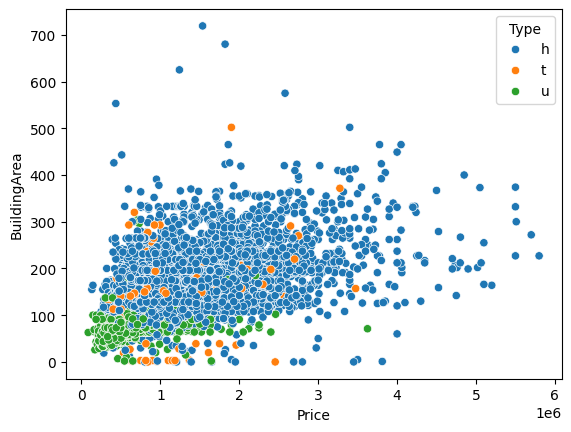

In [157]:
sns.scatterplot(y='BuildingArea', x = 'Price',hue = 'Type',data = data)

<Axes: xlabel='Price', ylabel='BuildingArea'>

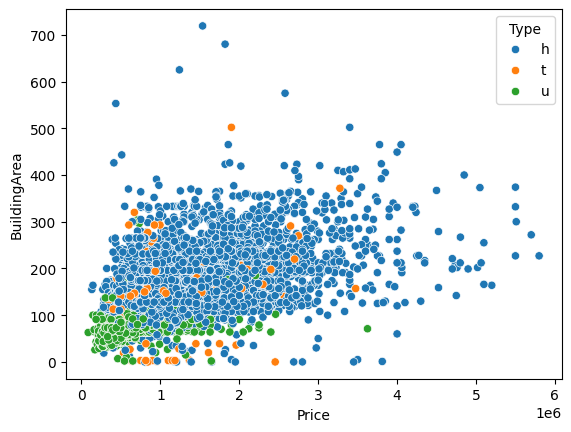

In [158]:
sns.scatterplot(y='BuildingArea', x = 'Price',hue = 'Type', data=data[data['Price'] < 7000000])

<Axes: xlabel='Price', ylabel='Distance'>

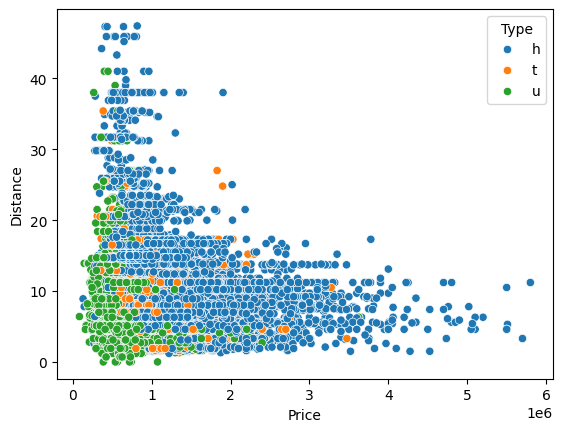

In [159]:
sns.scatterplot(y='Distance', x = 'Price',hue = 'Type',data = data)

<Axes: xlabel='Price', ylabel='Rooms'>

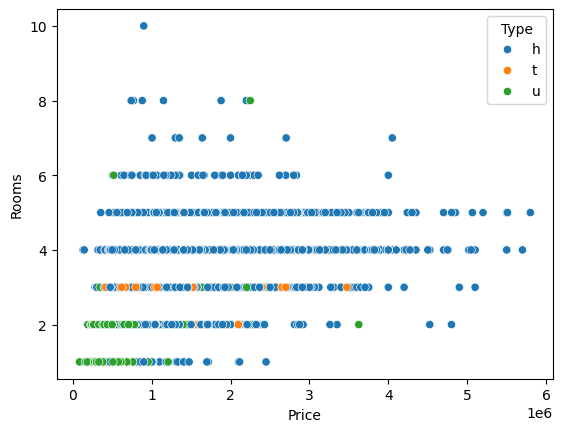

In [160]:
sns.scatterplot(y='Rooms', x = 'Price',hue = 'Type',data = data)

<Axes: xlabel='Price', ylabel='Bedroom2'>

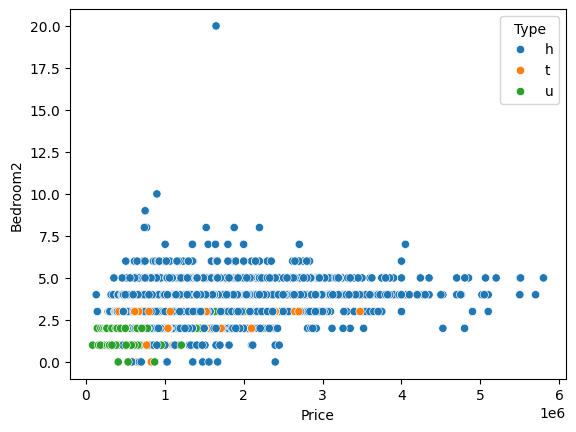

In [161]:
sns.scatterplot(y='Bedroom2', x = 'Price',hue = 'Type',data = data)

<Axes: xlabel='Price', ylabel='Bathroom'>

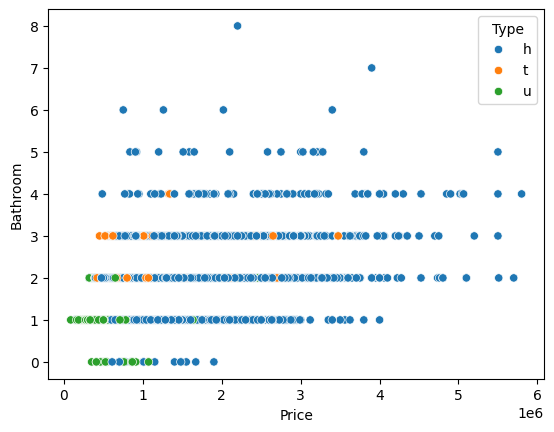

In [162]:
sns.scatterplot(y='Bathroom', x = 'Price',hue = 'Type',data = data)

<Axes: xlabel='Price', ylabel='Car'>

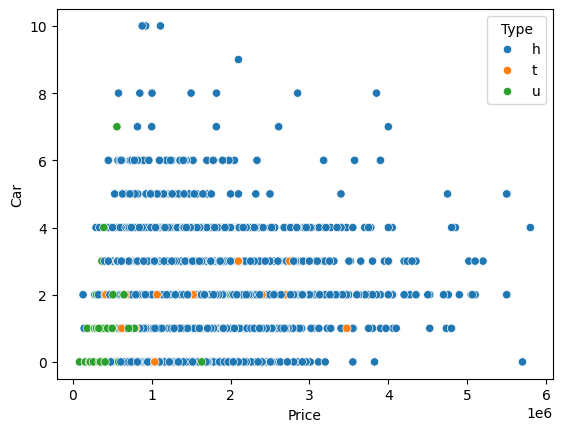

In [163]:
sns.scatterplot(y='Car', x = 'Price',hue = 'Type',data = data)

<Axes: xlabel='Price', ylabel='Landsize'>

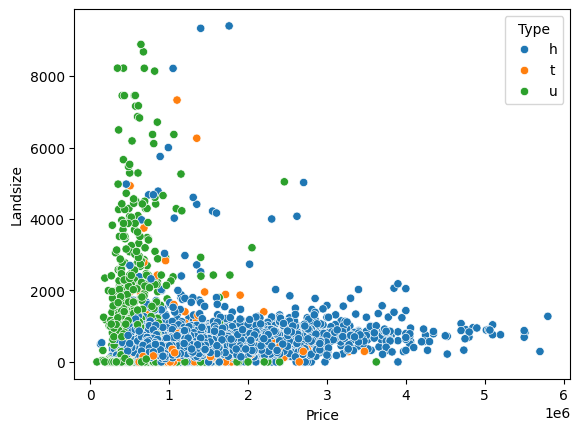

In [164]:
sns.scatterplot(y='Landsize', x = 'Price',hue = 'Type',data = data[data['Landsize'] < 10000])

<Axes: xlabel='Price', ylabel='Count'>

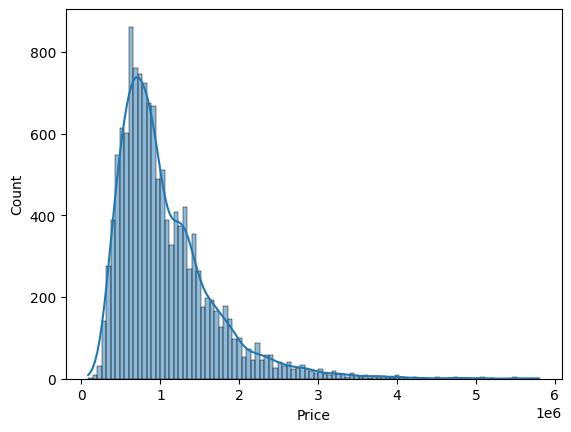

In [165]:
sns.histplot(data['Price'], kde=True)

<Axes: xlabel='Price', ylabel='Count'>

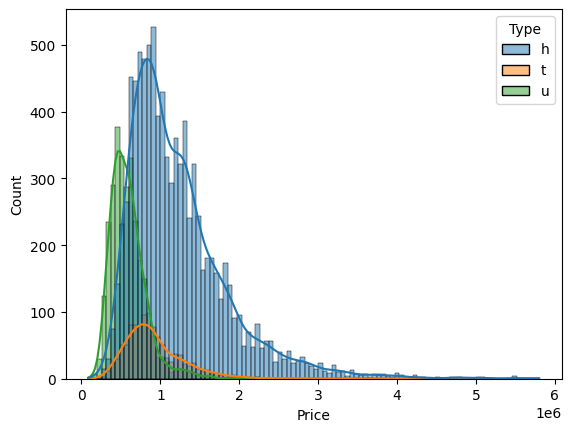

In [166]:
sns.histplot(data = data,x = 'Price',hue = 'Type', kde=True)

<Axes: xlabel='Price', ylabel='Count'>

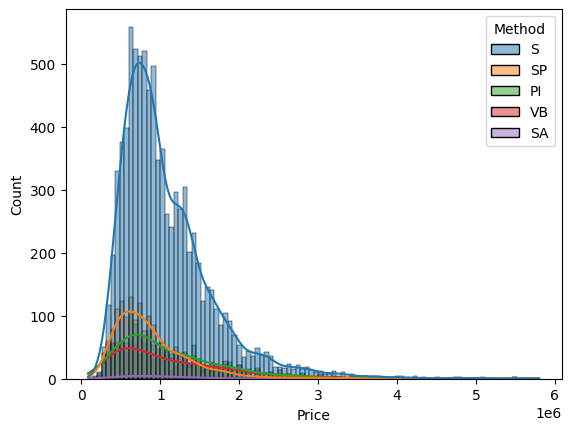

In [167]:
sns.histplot(data = data,x = 'Price',hue = 'Method', kde=True)

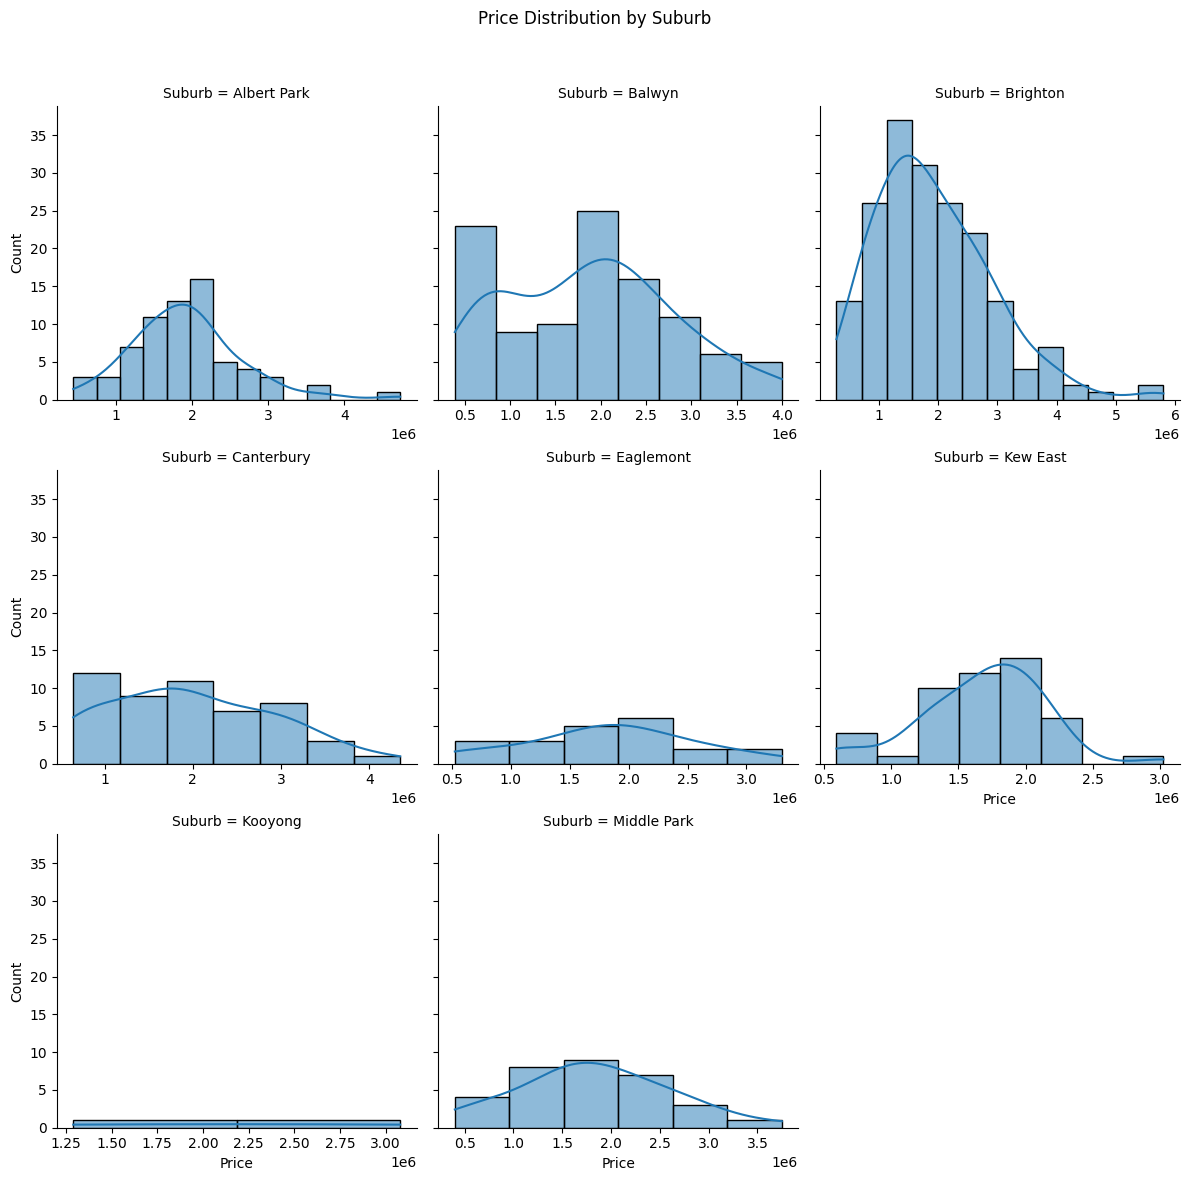

In [168]:
top_suburbs = data.groupby('Suburb')['Price'].median().sort_values(ascending=False).head(8).index
subset = data[data['Suburb'].isin(top_suburbs)]

g = sns.FacetGrid(subset, col='Suburb', col_wrap=3, height=4, sharex=False)
g.map(sns.histplot, 'Price', kde=True)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Price Distribution by Suburb')
plt.show()


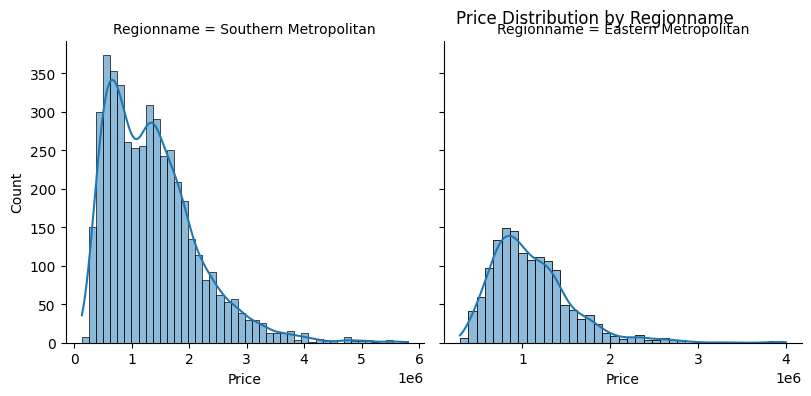

In [169]:
top_Regions = data.groupby('Regionname')['Price'].median().sort_values(ascending=False).head(2).index
subset = data[data['Regionname'].isin(top_Regions)]

g = sns.FacetGrid(subset, col='Regionname', col_wrap=3, height=4, sharex=False)
g.map(sns.histplot, 'Price', kde=True)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Price Distribution by Regionname')
plt.show()

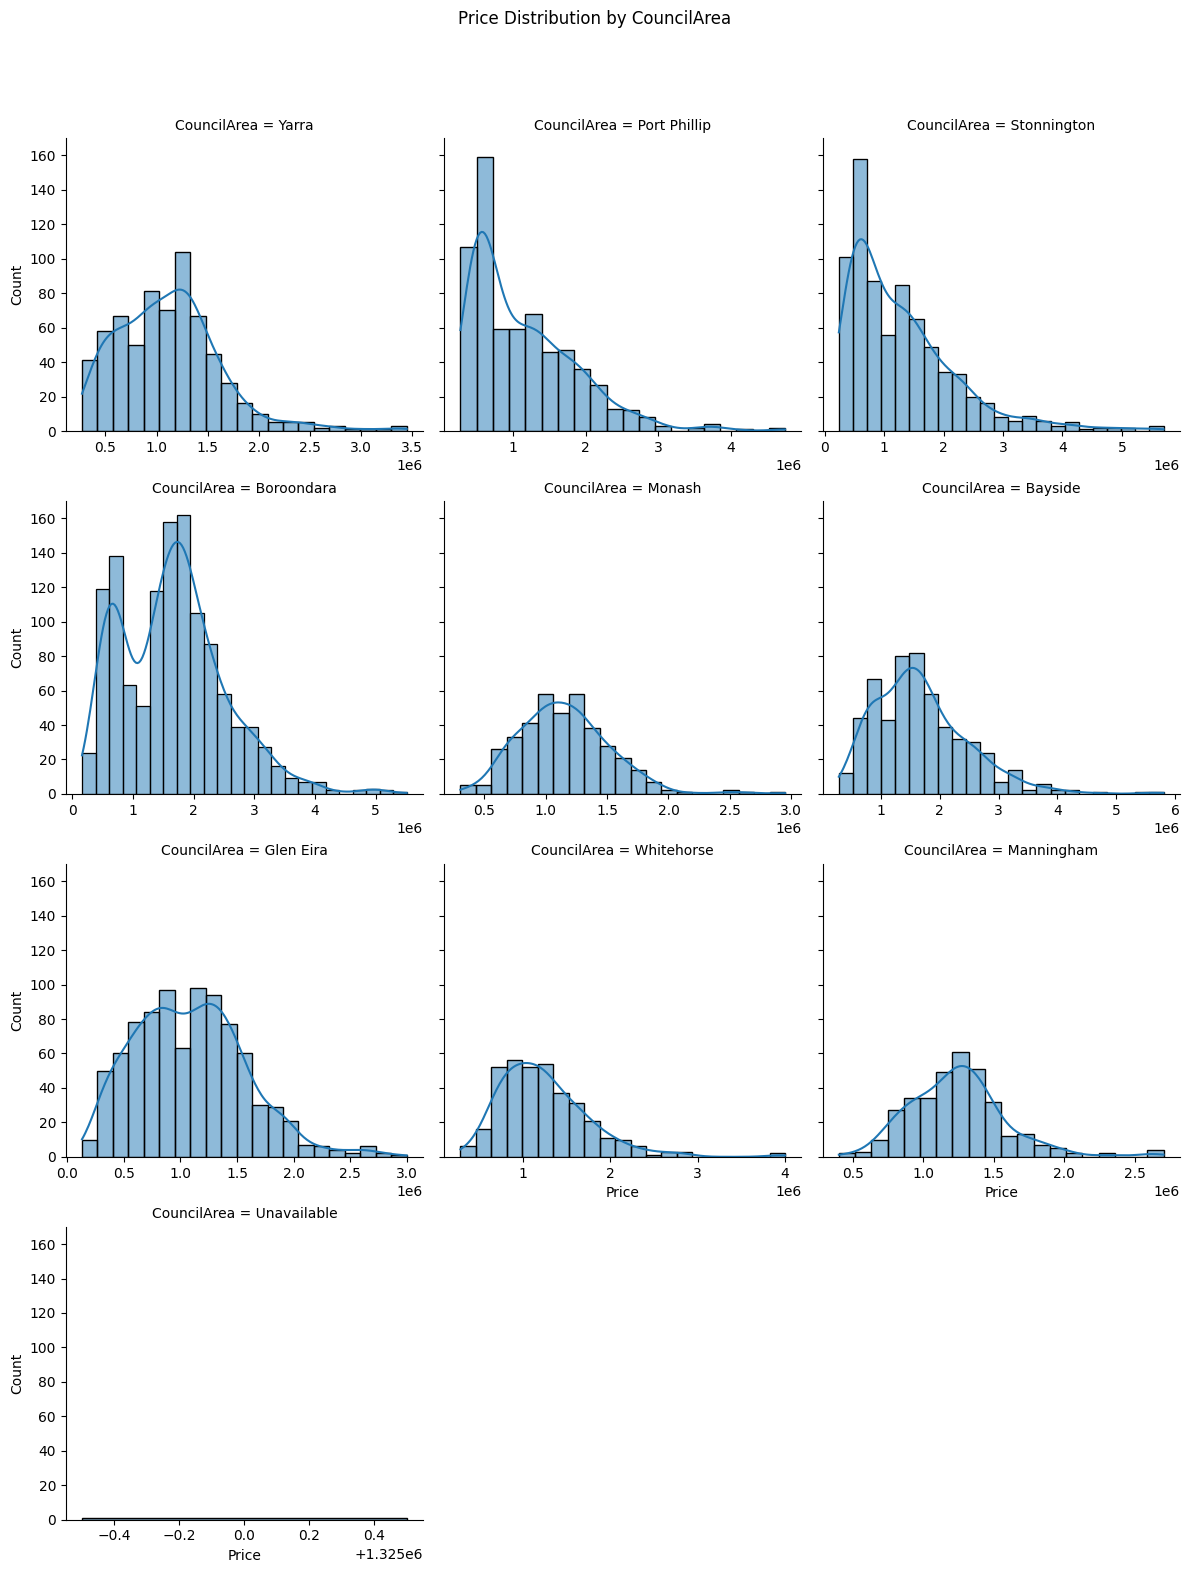

In [170]:
top_council = data.groupby('CouncilArea')['Price'].median().sort_values(ascending=False).head(10).index
subset = data[data['CouncilArea'].isin(top_council)]

g = sns.FacetGrid(subset, col='CouncilArea', col_wrap=3, height=4, sharex=False)
g.map(sns.histplot, 'Price', kde=True)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Price Distribution by CouncilArea')
plt.show()

<Axes: xlabel='Price', ylabel='Count'>

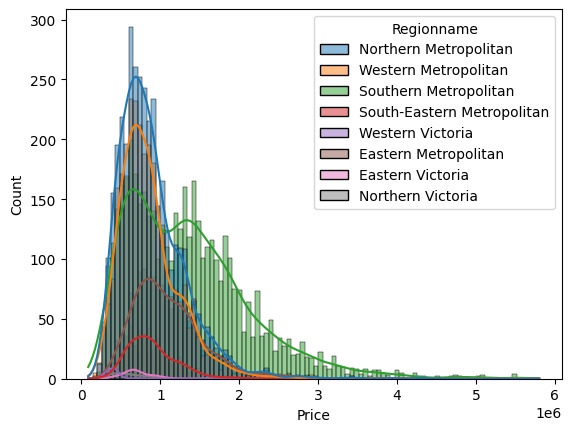

In [171]:
sns.histplot(data = data,x = 'Price',hue = 'Regionname', kde=True)

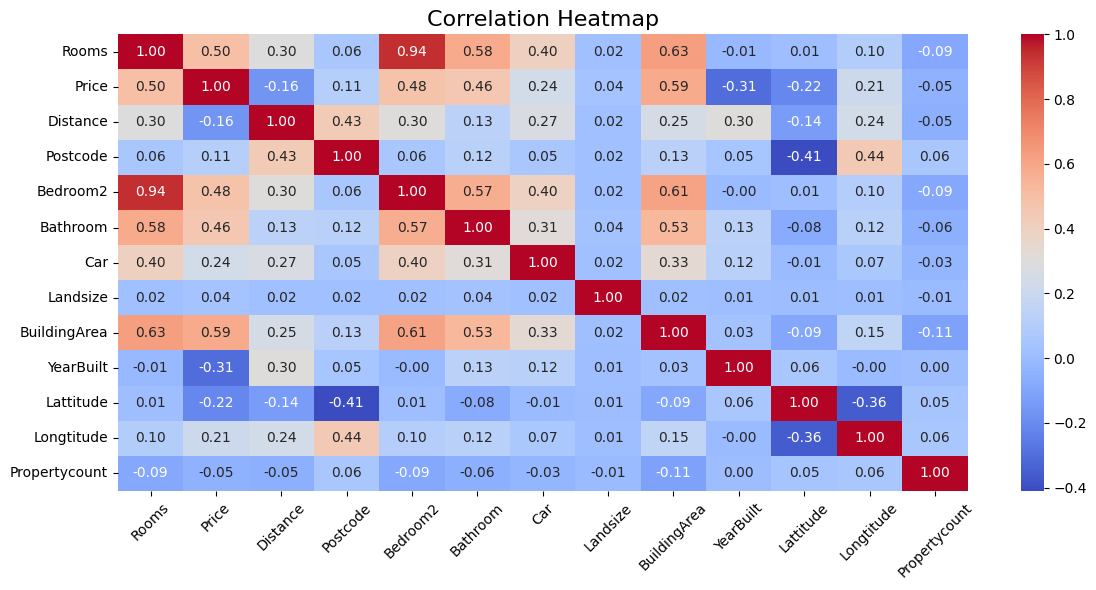

In [172]:
numeric_corr = data.corr(numeric_only=True)

plt.figure(figsize=(12, 6))
sns.heatmap(numeric_corr, annot=True, cmap='coolwarm', fmt=".2f")

plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<Axes: xlabel='Type', ylabel='count'>

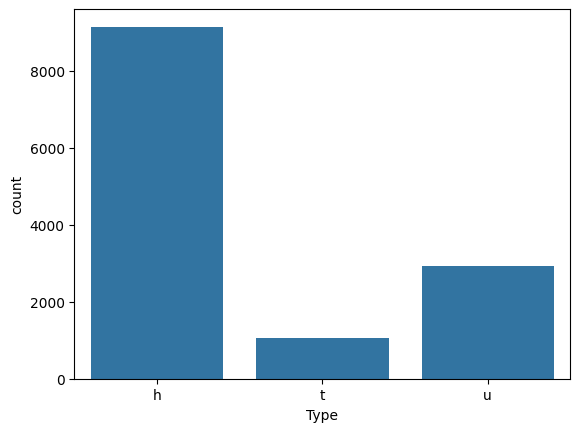

In [173]:
sns.countplot(x='Type', data=data)

<Axes: xlabel='Method', ylabel='count'>

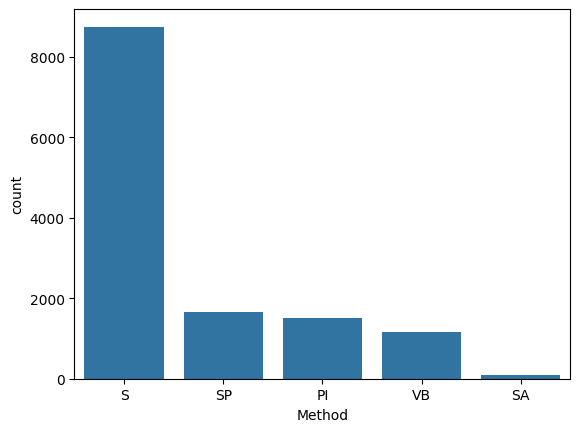

In [174]:
sns.countplot(x='Method', data=data)

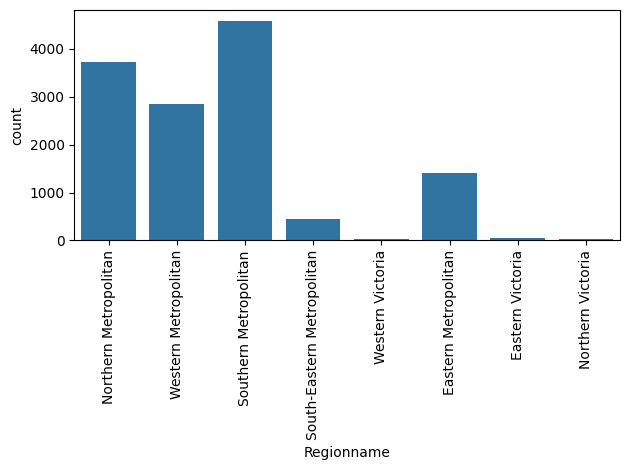

In [175]:
sns.countplot(x='Regionname', data=data)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# **Feature engineering**

Drop features that has low correlation with price

In [176]:
low_correlation = ['Postcode','Landsize','Propertycount']
data = data.drop(columns=low_correlation)

In [177]:
data['Method'].value_counts()

,count
Method,
S,8750
SP,1656
PI,1500
VB,1153
SA,88


In [178]:
data['SellerG'].value_counts()


,count
SellerG,
Nelson,1520
Jellis,1277
hockingstuart,1129
Barry,986
Ray,678
...,...
LLC,1
Hayeswinckle,1
McNaughton,1


In [179]:
threshold = 300
Seller_counts = data['SellerG'].value_counts()
rare_sellers = Seller_counts[Seller_counts < threshold].index.tolist()

# Replace rare methods with 'Other'
data['SellerG'] = data['SellerG'].apply(lambda x: 'Other' if x in rare_sellers else x)

# Optional: Check the new distribution
print(data['SellerG'].value_counts())

SellerG
Other            5596
Nelson           1520
Jellis           1277
hockingstuart    1129
Barry             986
Ray               678
Marshall          639
Buxton            615
Biggin            383
Brad              324
Name: count, dtype: int64


In [180]:
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

In [181]:
data = data.drop(columns = 'Date')

In [182]:
def top_sub(sub, top_suburbs):
    return 1 if sub in top_suburbs else 0

In [183]:
data['top_suburb'] = data['Suburb'].apply(lambda x: top_sub(x, top_suburbs))

In [184]:
def top_region(region, top_Regions):
    return 1 if region in top_Regions else 0

In [185]:
data['top_region'] = data['Regionname'].apply(lambda x: top_region(x, top_Regions))

In [186]:
def top_councils(council, top_council_list):
  if(council in top_council_list and council != 'Unavailable'):
    return 1
  else:
    return 0

In [187]:
data['top_council'] = data['CouncilArea'].apply(lambda x: top_councils(x, top_council))

dropping high multicollinearity features

In [188]:
data = data.drop(columns = ['Bedroom2'])

In [189]:
data = data.drop(columns = ['Address'])

In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13147 entries, 0 to 13151
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Suburb        13147 non-null  object 
 1   Rooms         13147 non-null  int64  
 2   Type          13147 non-null  object 
 3   Price         13147 non-null  float64
 4   Method        13147 non-null  object 
 5   SellerG       13147 non-null  object 
 6   Distance      13147 non-null  float64
 7   Bathroom      13147 non-null  float64
 8   Car           13147 non-null  float64
 9   BuildingArea  13147 non-null  float64
 10  YearBuilt     13147 non-null  float64
 11  CouncilArea   13147 non-null  object 
 12  Lattitude     13147 non-null  float64
 13  Longtitude    13147 non-null  float64
 14  Regionname    13147 non-null  object 
 15  Year          13147 non-null  int32  
 16  Month         13147 non-null  int32  
 17  top_suburb    13147 non-null  int64  
 18  top_region    13147 non-null  i

In [191]:
categorical_cols = ['Suburb', 'Type', 'Method', 'SellerG', 'CouncilArea', 'Regionname']

binary_encoder = ce.BinaryEncoder(cols=categorical_cols, drop_invariant=True)

data_encoded = binary_encoder.fit_transform(data)

In [192]:
data_encoded.head(2)

,Suburb_0,Suburb_1,Suburb_2,Suburb_3,Suburb_4,Suburb_5,Suburb_6,Suburb_7,Suburb_8,Rooms,...,Longtitude,Regionname_0,Regionname_1,Regionname_2,Regionname_3,Year,Month,top_suburb,top_region,top_council
0,0,0,0,0,0,0,0,0,1,2,...,144.9984,0,0,0,1,2016,12,0,0,1
1,0,0,0,0,0,0,0,0,1,2,...,144.9934,0,0,0,1,2016,2,0,0,1


In [193]:
y = data_encoded['Price']
x = data_encoded.drop(columns = 'Price')

In [194]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42)

In [195]:
len(X_train)

9202

In [196]:
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42)

In [197]:
len(X_val),len(X_test)

(1972, 1973)

In [198]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [199]:
reg = linear_model.LinearRegression()
reg.fit(X_train_scaled, y_train)

LinearRegression()

In [200]:
y_pred = reg.predict(X_test_scaled)

In [201]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 116390523263.08
Root Mean Squared Error (RMSE): 341160.55
R² Score: 0.6708


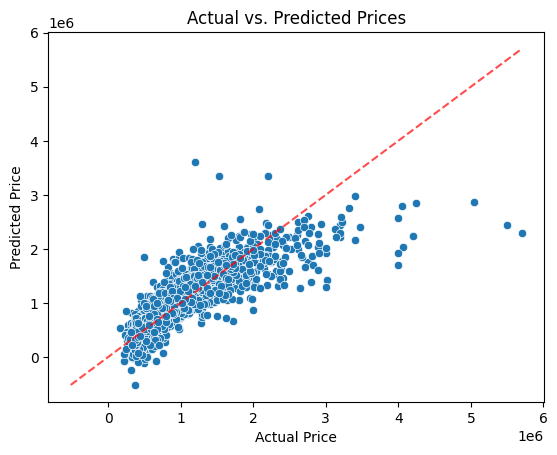

In [202]:
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Prices')
lims = [min(min(y_test), min(y_pred)), max(max(y_test), max(y_pred))]
plt.plot(lims, lims, 'r--', alpha=0.7)  # red dashed line

plt.show()

In [203]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [204]:
models_params = {
    "SVM": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"],
            "gamma": ["scale", "auto"]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "n_estimators": [100, 200, 300],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 5, 7,10]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    }
}

In [205]:
best_models = {}
model_results = []

for name, mp in models_params.items():
    print(f"Running Grid Search for {name}...")

    grid = GridSearchCV(mp["model"], mp["params"], cv=kf,scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },refit='r2', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)

    best_models[name] = grid.best_estimator_
    best_score = grid.best_score_
    best_params = grid.best_params_

    model_results.append((name, best_score, best_params))

    print(f"Best Parameters for {name}: {best_params}")
    print(f"Best CV result: {best_score:.4f}\n")

Running Grid Search for SVM...
Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best CV result: 0.5111

Running Grid Search for XGBoost...
Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best CV result: 0.7782

Running Grid Search for Random Forest...
Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 100}
Best CV result: 0.7617



In [209]:
best_xgb = XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=300, use_label_encoder=False)
best_xgb.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:29:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [211]:
xgb_y_val = best_xgb.predict(X_val_scaled)

In [214]:
mse_xgb_val = mean_squared_error(y_val, xgb_y_val)
rmse_xgb_val = np.sqrt(mse)
r2_xgb_val = r2_score(y_val, xgb_y_val)

print(f"Mean Squared Error (MSE): {mse_xgb_val:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb_val:.2f}")
print(f"R² Score: {r2_xgb_val:.4f}")

Mean Squared Error (MSE): 72252678358.20
Root Mean Squared Error (RMSE): 341160.55
R² Score: 0.8012


In [210]:
xgb_y_pred = best_xgb.predict(X_test_scaled)

In [212]:
mse_xgb = mean_squared_error(y_test, xgb_y_pred)
rmse_xgb = np.sqrt(mse)
r2_xgb = r2_score(y_test, xgb_y_pred)

print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")

Mean Squared Error (MSE): 69144348057.78
Root Mean Squared Error (RMSE): 341160.55
R² Score: 0.8044


In [218]:
best_random_forest = RandomForestRegressor(max_depth=20, min_samples_split=10, n_estimators=100)
best_random_forest.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=10)

In [219]:
forest_y_val = best_random_forest.predict(X_val_scaled)

In [220]:
forest_mse_val = mean_squared_error(y_val, forest_y_val)
forest_rmse_val = np.sqrt(forest_mse_val)
forest_r2_val = r2_score(y_val, forest_y_val)

print(f"Mean Squared Error (MSE): {forest_mse_val:.2f}")
print(f"Root Mean Squared Error (RMSE): {forest_rmse_val:.2f}")
print(f"R² Score: {forest_r2_val:.4f}")

Mean Squared Error (MSE): 74761425070.81
Root Mean Squared Error (RMSE): 273425.36
R² Score: 0.7943


In [221]:
forest_y_test = best_random_forest.predict(X_test_scaled)

In [223]:
forest_mse_test = mean_squared_error(y_test, forest_y_test)
forest_rmse_test = np.sqrt(forest_mse_test)
forest_r2_test = r2_score(y_test, forest_y_test)

print(f"Mean Squared Error (MSE): {forest_mse_test:.2f}")
print(f"Root Mean Squared Error (RMSE): {forest_rmse_test:.2f}")
print(f"R² Score: {forest_r2_test:.4f}")

Mean Squared Error (MSE): 72386068865.25
Root Mean Squared Error (RMSE): 269046.59
R² Score: 0.7953


In [231]:
base_models = [
    ('rf', RandomForestRegressor(max_depth=20, min_samples_split=10, n_estimators=100)),
    ('xgb', XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=300, use_label_encoder=False))
]


In [233]:
meta_model = linear_model.LinearRegression()

In [234]:
stack = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,  # full cross-validation
    passthrough=False  # set to True if you also want raw features passed to the meta-model
)

In [235]:
stack.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:03:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:04:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:04:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:04:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


StackingRegressor(cv=5,
                  estimators=[('rf',
                               RandomForestRegressor(max_depth=20,
                                                     min_samples_split=10)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_poli...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                  final_estimator=LinearRegression())

In [236]:
y_var = stack.predict(X_val_scaled)

In [237]:
mse_var = mean_squared_error(y_val, y_var)
rmse_var = np.sqrt(mse_var)
r2_var = r2_score(y_val, y_var)

print(f"Stacked MSE: {mse_var:.2f}")
print(f"Stacked RMSE: {rmse_var:.2f}")
print(f"Stacked R² Score: {r2_var:.4f}")

Stacked MSE: 70607208922.47
Stacked RMSE: 265720.17
Stacked R² Score: 0.8057


In [238]:
y_pred = stack.predict(X_test_scaled)

In [239]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Stacked MSE: {mse:.2f}")
print(f"Stacked RMSE: {rmse:.2f}")
print(f"Stacked R² Score: {r2:.4f}")

Stacked MSE: 66969863686.80
Stacked RMSE: 258785.36
Stacked R² Score: 0.8106


In [240]:
pickle.dump(stack,open('stacked_model.pkl','wb'))
pickle.dump(best_random_forest,open('random_forrest.pkl','wb'))
pickle.dump(best_xgb,open('xgb.pkl','wb'))
